# 1: Preparing Alpha Factors and Features

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2000-01-01'
END = '2024-01-01'

In [5]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [6]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]

In [7]:
T = [1, 5, 10, 21, 42, 63]

## Loading Merval Stock Prices & Meta Data

In [48]:
DATA_STORE = '../data/assets.h5'
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['merval/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .swaplevel()
              .sort_index())
    metadata = (store['merval/stocks'].loc[:, ['marketcap', 'sector']])

In [49]:
prices.volume /= 1e3 # make vol figures a bit smaller
prices.index.names = ['symbol', 'date']
metadata.index.name = 'symbol'

## Remove stocks with insufficient observations

### Align price and meta data

In [51]:
metadata = metadata[~metadata.index.duplicated() & metadata.sector.notnull()]
metadata.sector = metadata.sector.str.lower().str.replace(' ', '_')

In [52]:
shared = (prices.index.get_level_values('symbol').unique()
          .intersection(metadata.index))
metadata = metadata.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

### Rank assets by Rolling Average Dollar Volume

#### Compute dollar volume

In [54]:
prices['dollar_vol'] = prices[['close', 'volume']].prod(1).div(1e3)

#### 21-day moving average

In [55]:
# compute dollar volume to determine universe
dollar_vol_ma = (prices
                 .dollar_vol
                 .unstack('symbol')
                 .rolling(window=21, min_periods=1) # 1 trading month
                 .mean())

#### Rank stocks by moving average

In [56]:
prices['dollar_vol_rank'] = (dollar_vol_ma
                            .rank(axis=1, ascending=False)
                            .stack('symbol')
                            .swaplevel())

In [57]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 299201 entries, ('ALUA.BA', Timestamp('2002-07-22 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             299201 non-null  float64
 1   close            299201 non-null  float64
 2   low              299201 non-null  float64
 3   high             299201 non-null  float64
 4   volume           299201 non-null  float64
 5   dollar_vol       299201 non-null  float64
 6   dollar_vol_rank  299201 non-null  float64
dtypes: float64(7)
memory usage: 17.0+ MB


## Add some Basic Factors

### Compute the Relative Strength Index

In [58]:
rsi = prices.groupby(level='symbol').close.apply(RSI)
prices['rsi'] = rsi.values

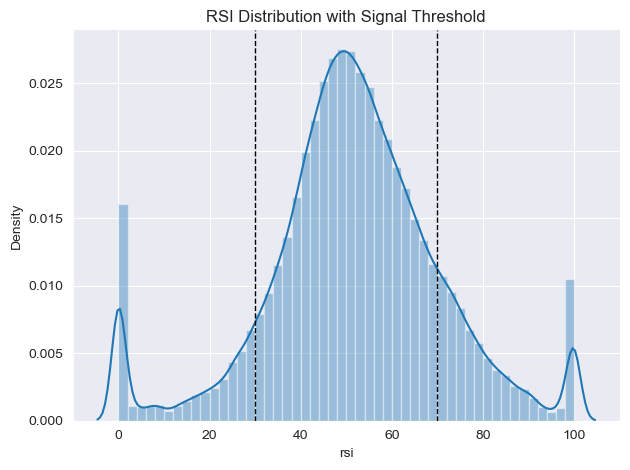

In [59]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

### Compute Bollinger Bands

In [60]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [61]:
bb = prices.groupby(level='symbol').close.apply(compute_bb)

prices['bb_high'] = bb['bb_high'].values
prices['bb_low'] = bb['bb_low'].values


In [62]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

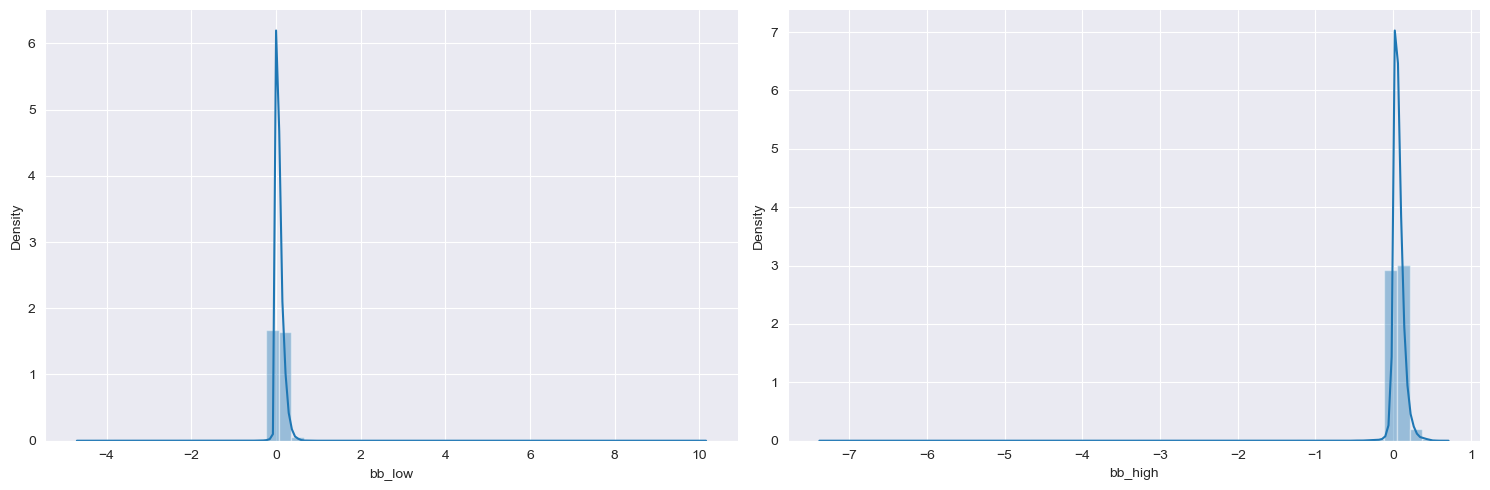

In [63]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();

### Compute Average True Range

In [64]:
prices['NATR'] = prices.groupby(level='symbol', 
                                group_keys=False).apply(lambda x: 
                                                        talib.NATR(x.high, x.low, x.close))

In [65]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [66]:
prices['ATR'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_atr))

### Compute Moving Average Convergence/Divergence

In [67]:
by_ticker = prices.groupby('symbol', group_keys=False)
prices['ppo'] = by_ticker.close.apply(talib.PPO)

In [68]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [69]:
prices['MACD'] = (prices
                  .groupby('symbol', group_keys=False)
                  .close
                  .apply(compute_macd))

### Combine Price and Meta Data

In [71]:
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

## Compute Returns

### Historical Returns

In [72]:
by_sym = prices.groupby(level='symbol').close
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

### Daily historical return deciles

In [73]:
t = 1
def qcut(x):
	return pd.qcut(x, q=10, labels=False, duplicates='drop')
    
prices[f'r{t:02}'].groupby(level='symbol').apply(lambda x: x.iloc[1:]).groupby(level='date').apply(qcut).values

array([1., 3., 0., ..., 7., 2., 8.])

In [76]:
prices[f'r{t:02}'].info()

<class 'pandas.core.series.Series'>
MultiIndex: 299201 entries, ('ALUA.BA', Timestamp('2002-07-22 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Series name: r01
Non-Null Count   Dtype  
--------------   -----  
299143 non-null  float64
dtypes: float64(1)
memory usage: 3.3+ MB


### Compute Forward Returns

In [77]:
for t in [1, 5, 21]:
    prices[f'r{t:02}_fwd'] = prices.groupby(level='symbol')[f'r{t:02}'].shift(-t)

## Create time and sector dummy variables

In [82]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday

## Store Model Data

In [85]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 299201 entries, ('ALUA.BA', Timestamp('2002-07-22 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             299201 non-null  float64
 1   close            299201 non-null  float64
 2   low              299201 non-null  float64
 3   high             299201 non-null  float64
 4   volume           299201 non-null  float64
 5   dollar_vol       299201 non-null  float64
 6   dollar_vol_rank  299201 non-null  float64
 7   rsi              298389 non-null  float64
 8   bb_high          298089 non-null  float64
 9   bb_low           298093 non-null  float64
 10  NATR             298389 non-null  float64
 11  ATR              298389 non-null  float64
 12  ppo              297751 non-null  float64
 13  MACD             297287 non-null  float64
 14  sector           299201 non-null  int64  
 15  r0

In [86]:
prices.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).to_hdf('../data.h5', 'model_data')